# Automatic Variational ABC
This file executes the algotrithm presented in the article: Moreno et. al. (2010) Automatic Variational ABC.

Algorithm code is saved to file ABC.py, that should be in the same directory as this notebook. Cache is emptied in the beginning of the two problems, there's a prompt that must be answered to.

Task is to:
* implement algorithm 1
* test your implementation by replicating the simulated tests (4.1-4.2)
* compare your results to the results in the paper

## Algorithm 1
1. Specify simulation code for $f(\theta, u)$ and simulator randomness $p(u)$
2. Specify reparametrization $Q(\theta, \phi)$ in terms or parameterless $Q_0(\nu)$
3. $\phi$ <-- initialize parameters
4. repeat until convergence
    * $\nu$ <-- samples from $Q_0(\nu)$
    * $u$ <-- samples from $p(u)$
    * $g$ <-- $\nabla L_\phi(\phi, \nu, u) $
    * $\phi$ <-- run one step of an adaptive gradient algorithm using $g$



## Problem 1: Infer distribution for probability in Bernoulli distribution
There are M Bernoulli samples, each with success probability $\theta$. The task is to infer a distribution for $\theta$. Observed data $y$ is a vector of zero's and one's, and $k$ is the number of successes. Number of trials is 100 and true value of k=70.

With $beta(1,1)$ prior, the true posterior is $beta(k+1, M-k+1)$.

Because the method is based on gradients the continuous normal approximation for binomial distribution is used instead of the discrete true distribution.

$\epsilon$ is set to $\theta(1-\theta)^(0.5)$

Variational posterior is $Q_\phi(\theta)=Kumaraswamy(a,b)$, with initial values (1,1). Kumaraswamy distribution is similar to beta distribution, but has a closed for CDF. Closed form CDF is needed to generate samples given uniform distribution $Q_0(\nu)=U(0,1)$.

For Gaussian approximation $N(0,1)$ is used.

In [19]:
%reset

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import binom
from scipy.special import gamma
from scipy.misc import derivative
from scipy.stats import beta
npr.seed(42)

# ABC.py must be in the same directory as this notebook
import ABC
import importlib
importlib.reload(ABC)

# 1 Bernoulli problem
## Target functions
def fTargetBernoulli(parPhi0, nu, u, binN=100, yy=70):
    parPhi=np.exp(parPhi0)
    # binN: number of bernoulli tries
    # yy: number of successes in the simulation
    # Express theta as a function of phi and nu
    # * Use the inverse of function of Kumaraswamy CDF to transform Uniform distribution to Kumaraswamy
    # * phi[0]: a-parameter of Kumaraswamy distribution
    # * phi[1]: b-parameter of Kumaraswamy distribution
    # * theta: vector[samplesize] of success probabilities
    theta = (1-(1-nu)**(1/parPhi[1]))**(1/parPhi[0])
    # Transform u~N(0,1) and theta to the normal approximation of binomial distribution 
    # to get xx: the approximate number of successes
    prob0=0.0
    for i in range(len(theta)):
        # First mean is over the u-values
        # Calculate the probability of achieving yy=70 successes with 
        # expected value=xx0 and variance=theta*(1-theta)
        xx0=np.mean(binN*theta[i] + (binN*theta[i]*(1-theta[i])**2)*u)
        prob0+=lNormal(yy, xx0, binN*theta[i]*(1-theta[i]))
    # Second mean is over the theta values
    lProbEpsilon=np.mean(prob0)
    xx=100*np.exp(lProbEpsilon)
    # Calculate the Kullback-Leibler divergence
    # * Use normal approximation with the expected value = yy to check, how likely xx is
    KL=lKumaraswamy(theta, parPhi[0], parPhi[1]) / len(theta) - lNormal(xx, yy, binN*(70/100)*(1-70/100))
    return lProbEpsilon - KL

def lNormal(x, mu, sigma2):
    return np.sum(-0.5*np.log(2*np.pi*sigma2) - 0.5*(x-mu)**2/sigma2)
def lKumaraswamy(x, a, b):
    return np.sum(np.log(a)+np.log(b)+(a-1)*np.log(x)+(b-1)*np.log(1-x**a))
# Function for storing the simulated theta values
def CalculateProbability(parPhi, nu):
    # Phi is actually log phi, so exponentiate
    parPhi=np.exp(parPhi)
    return np.mean((1-(1-nu)**(1/parPhi[1]))**(1/parPhi[0]))

# Function call
# Parameters
# Phi0: original values of phi
# Initialize with Kumaraswamy(1,1) --> Targetfunction takes exponent, so first parameter is [0,0]
parPhi0=np.array([0.0,0.0])
# nIterations: number of iterations in the main program
parNIterations=500
# fTarget: target function
parTarget=fTargetBernoulli
# fNu: function to simulate nu
parFNu=lambda x:npr.uniform(size=x)
# nSample: sample size (=length of Nu
parNSample=10
# fU: function to simulate u
parFU=lambda x:npr.normal(size=x)
# nParticle: number of particles (=length of u)
parNParticle=10
# rho_0, t0: parameters defining the step length have default values

# L=S=10 (10 particles and 10 simulations, 500 iterations) 
samplePhi10, sampleLb10, sampleGrad10, sampleTheta10=ABC.avabc(parPhi0,parNIterations,parTarget,parFNu,parNSample,parFU,parNParticle,CalculateProbability)
#L=S=1
parNSample=1
parNParticle=1
samplePhi1, sampleLb1, sampleGrad1, sampleTheta1=ABC.avabc(parPhi0,parNIterations,parTarget,parFNu,parNSample,parFU,parNParticle,CalculateProbability)

print('Last theta10: ', sampleTheta10[parNIterations-1])
print('Last theta1: ', sampleTheta1[parNIterations-1])

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Returning values
Returning values
Last theta10:  0.6646270457159426
Last theta1:  0.661308951096523


In [20]:
print('True expected value for posterior theta: ', (70+1) / ((100-70+1)+70+1))
print('Mean, median and std of the sample (10 particles and simulations): ', np.mean(sampleTheta10), np.median(sampleTheta10), np.std(sampleTheta10, ddof=2))
print('Mean, median and std of the sample (1 particles and simulations): ', np.mean(sampleTheta1), np.median(sampleTheta1), np.std(sampleTheta1, ddof=2))

True expected value for posterior theta:  0.696078431372549
Mean, median and std of the sample (10 particles and simulations):  0.6984128925321474 0.6998926151095702 0.04150340401129875
Mean, median and std of the sample (1 particles and simulations):  0.6956944740781315 0.71278052502594 0.11597048660601329


(array([ 90., 116., 129.,  61.,  34.,  14.,  12.,   6.,   8.,   7.,   5.,
          3.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-22.77440483, -13.72192376,  -4.66944269,   4.38303838,
         13.43551946,  22.48800053,  31.5404816 ,  40.59296267,
         49.64544374,  58.69792481,  67.75040588,  76.80288695,
         85.85536803,  94.9078491 , 103.96033017, 113.01281124,
        122.06529231, 131.11777338, 140.17025445, 149.22273553,
        158.2752166 , 167.32769767, 176.38017874, 185.43265981,
        194.48514088, 203.53762195, 212.59010302, 221.6425841 ,
        230.69506517, 239.74754624, 248.80002731, 257.85250838,
        266.90498945, 275.95747052, 285.00995159, 294.06243267,
        303.11491374, 312.16739481, 321.21987588, 330.27235695,
        339.324838

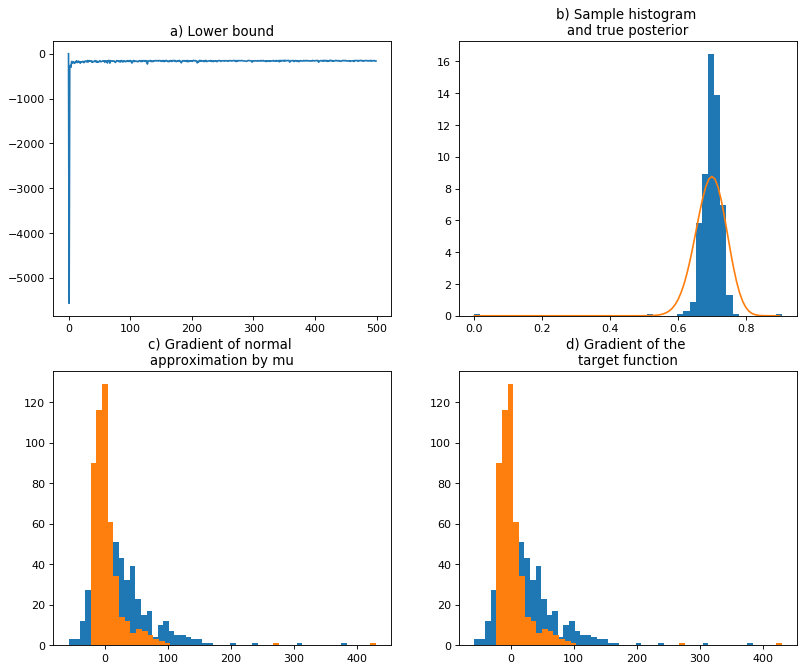

In [21]:
# Plot results:
#fig1, (ax2, ax3,ax3,ax4) = plt.subplots(nrows=2, ncols=2) # two axes on figure
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.title('a) Lower bound')
plt.plot(sampleLb10)
plt.subplot(222)
plt.title('b) Sample histogram \nand true posterior')
plt.hist(sampleTheta10, bins=50, density=True)
# True posterior is Beta(k+1, M-k+1), M=100, k=70
plotx=np.linspace(0.0,0.9, 100)
plt.plot(plotx, beta.pdf(plotx, 70+1, 100-70+1))
plt.subplot(223)
# Calculate gradient for mu
plt.title('c) Gradient of normal \napproximation by mu')
plt.hist(sampleGrad10[10:], bins=50)
plt.hist(sampleGrad1[10:], bins=50)

plt.subplot(224)
plt.title('d) Gradient of the \ntarget function')
plt.hist(sampleGrad10[10:], bins=50)
plt.hist(sampleGrad1[10:], bins=50)

## Problem 2: Infer the rate $\lambda$ for exponential distribution
The prior is $Gamma(\alpha, \beta)$ prior and data vector $y$ of M samples from the exponential distribution. The true posterior is $Gamma(\alpha+M, \beta+y̅M)$. The simulator draws samples from the exponential distribution.

Summary statistics used here are S(**x**)=x̅ and S(**y**)=y̅. 

True values are $\lambda$=1 and M=15.

At each iteration take samples $\nu^{(s)}$ from $Q_0(\nu) ~ N(0,I)$, then calculate:

$\theta = g(\phi, \nu^{(s)}) = exp(\mu, \Sigma \cdot \nu_s)$

Initialize both $\mu$ and $\Sigma$ by drawing from U(2,3). Convergence parameters are approximately $\mu=0$ and $\sigma=0.3$. Use S=10 samples and L=10 particles.



In [35]:
%reset

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import binom
from scipy.special import gamma
from scipy.misc import derivative
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import lognorm
import math


npr.seed(42)

# ABC.py must be in the same directory as this notebook
import ABC
import importlib
importlib.reload(ABC)

# 2 Exponential problem
## Target functions
def TargetExponential(parPhi,nu, u, yyMean, printInfo=False, M=15):
    # phi[0]: mu (not restricted)
    # phi[1]: sigma(>0)
    mu=(parPhi[0])
    sigma=np.exp(parPhi[1])
    theta = np.exp(mu+sigma*nu)
    if printInfo: print('TargetExponential, theta is: ', theta)
    # Generate x-values from u-values and theta-values
    # First create a matrix with u-values in columns and theta values in rows
    xx0=(-1/np.exp(theta) * np.log(1-u[:,np.newaxis]))
    # Row means to get x-values
    xx1=np.mean(xx0, axis=0)
    # Variance parameter for comparion of the true value and generated values
    epsilon2=np.std(xx1)**2/M
    # Calculate the mean of log-probabilities
    if printInfo: print('xx1, yyMean, epsilon2: ', xx1, yyMean, epsilon2)
    lProbEpsilon=lNormal(xx1, yyMean, epsilon2)/len(theta)
    if printInfo: print('fTargetExponential,lProbEpsilon: ', lProbEpsilon)
      
    # Calculate the Kullback-Leibler divergence
    KL=lNormal(np.log(theta), mu, sigma)/len(theta)-lExponential(yyMean, M, theta)/len(theta)
    if printInfo: print('***fTargetExponential, KL: ', KL)
    if printInfo: print('***fTargetExponential, KL, 1: ', lNormal(np.log(theta), mu, sigma), len(theta))
    if printInfo: print('***fTargetExponential, KL, 2: ', lExponential(yyMean, M, theta)/len(theta))             
    return lProbEpsilon - KL

def lNormal(x, mu, sigma2):
    return np.sum(-0.5*np.log(2*np.pi*sigma2) - 0.5*(x-mu)**2/sigma2)

def lLognormal(x, mu, sigma):
    if sigma == 0.0: sigma=0.00000001
    if float("-inf")==np.sum(-np.log(x)-np.log(sigma)-0.5*np.log(2*np.pi)-1/(2*sigma**2)*((np.log(x)-mu)**2)):
        print('lLognormal produced -inf')
    return np.sum(-np.log(x)-np.log(sigma)-0.5*np.log(2*np.pi)-1/(2*sigma**2)*((np.log(x)-mu)**2))

def lExponential(meanX, n, theta0):
    return np.sum(n*np.log(theta0) - theta0*n*meanX)
def CalculateLambda(parPhi, nu):
    return np.mean(np.exp(parPhi[0]+np.exp(parPhi[1])*nu))

# Function call
# Parameters
# Phi0: original values of phi
# Unitialize with U(2,3)
parPhi0=npr.uniform(low=2.0, high=3.0, size=2)
# Sigma needs to be positive, so it is exponentiated later, thus taking a logarithm
parPhi0[1]=np.log(parPhi0[1])
# nIterations: number of iterations in the main program
parNIterations=3500
# fTarget: target function: fTargetExponential
# fNu: function to simulate nu
parFNu=lambda x:npr.normal(size=x)
# nSample: sample size (=length of Nu
parNSample=10
# fU: function to simulate u
parFU=lambda x:npr.uniform(size=x)
# nParticle: number of particles (=length of u)
parNParticle=10
# rho_0, t0: parameters defining the step length have default values

# Simulate S(y)=mean(y) from exponential distribution M=1,lambda=1.0
targetMean=np.mean(npr.exponential(scale=1.0, size=15))
print('Target mean is: ', targetMean)
TargetExponential2=lambda parPhi,nu, u: TargetExponential(parPhi,nu, u, yyMean=targetMean)

# Parameters of avabc-function
# Phi0: original values of phi
# nIterations: number of iterations in the main program
# fTarget: target function
# fNu: function to simulate nu
# nSample: sample size (=length of Nu)
# fU: function to simulate u
# nParticle: number of particles (=length of u)
# rho_0, t0: parameters defining the step length
samplePhi10, sampleLb10, sampleGrad10, sampleTheta10=ABC.avabc(parPhi0,parNIterations,TargetExponential2,parFNu,parNSample,parFU,parNParticle, CalculateLambda,printInfo=False,rho_0=0.05, t0=500)
parNSample=1; parNParticle=1
samplePhi1, sampleLb1, sampleGrad1, sampleTheta1=ABC.avabc(parPhi0,parNIterations,TargetExponential2,parFNu,parNSample,parFU,parNParticle, CalculateLambda,printInfo=False,rho_0=0.05, t0=500)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Target mean is:  0.8737219567281532


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


Returning values


C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:52: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: divide by zero encountered in true_divide
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
C:\Users\Suvi\Anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:76: RuntimeWarning: divide by zero encountered in double_scalars


Returning values


In [37]:
print('Converge parameters are mu=0.0 and sigma=0.3')
print('In the data corresponding parameters are: ', np.mean(samplePhi10[:,0]), (np.mean(samplePhi10[:,1])))
print('Lambda is set to one')
print('In the sample mean and median of theta: ', np.mean(sampleTheta10), np.median(sampleTheta10))

Converge parameters are mu=0.0 and sigma=0.3
In the data corresponding parameters are:  -0.9258137163804507 0.3367651762141699
Lambda is set to one
In the sample mean and median of theta:  1.1635570282121823 0.8346921502668272


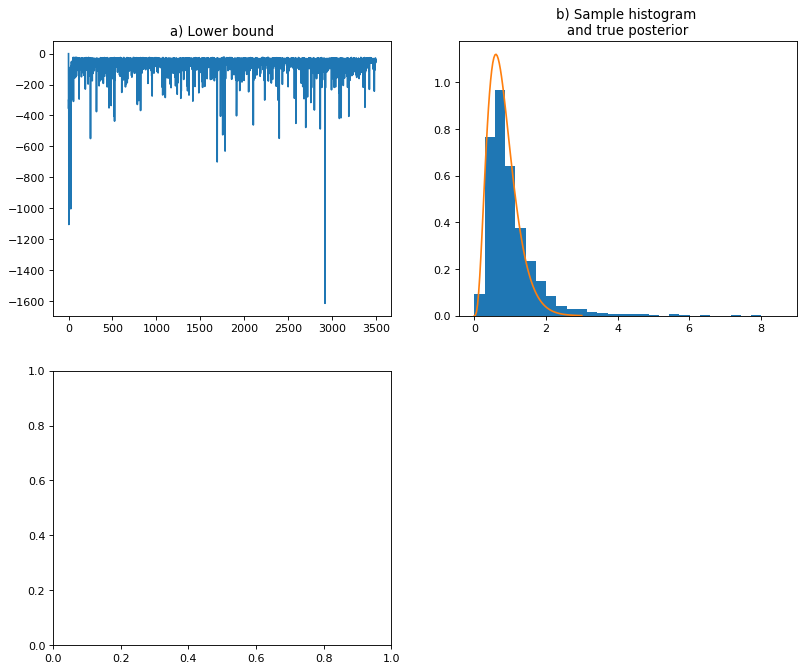

In [38]:

# Plot results:
#fig1, (ax2, ax3,ax3,ax4) = plt.subplots(nrows=2, ncols=2) # two axes on figure
fig=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(221)
plt.title('a) Lower bound')
plt.plot(sampleLb10)
plt.subplot(222)
plt.title('b) Sample histogram \nand true posterior')
#plt.hist(sampleTheta10, bins=25, density=True)
plt.hist(sampleTheta10[sampleTheta10<10], bins=30, density=True)
# True posterior is Gamma(alpha=), alpha=, beta=70
plotx=np.linspace(0.0,3.0, 100)
plt.plot(plotx, gamma.pdf(plotx, a=4.0, scale=0.2))
plt.subplot(223)


(array([ 93., 760., 963., 637., 376., 235., 150.,  85.,  43.,  27.,  28.,
         18.,  11.,   7.,   6.,   8.,   7.,   2.,   1.,   7.,   3.,   1.,
          2.,   0.,   0.,   2.,   0.,   2.,   1.,   1.]),
 array([6.66114953e-312, 2.86192567e-001, 5.72385135e-001, 8.58577702e-001,
        1.14477027e+000, 1.43096284e+000, 1.71715540e+000, 2.00334797e+000,
        2.28954054e+000, 2.57573311e+000, 2.86192567e+000, 3.14811824e+000,
        3.43431081e+000, 3.72050338e+000, 4.00669594e+000, 4.29288851e+000,
        4.57908108e+000, 4.86527365e+000, 5.15146621e+000, 5.43765878e+000,
        5.72385135e+000, 6.01004392e+000, 6.29623648e+000, 6.58242905e+000,
        6.86862162e+000, 7.15481419e+000, 7.44100675e+000, 7.72719932e+000,
        8.01339189e+000, 8.29958445e+000, 8.58577702e+000]),
 <a list of 30 Patch objects>)

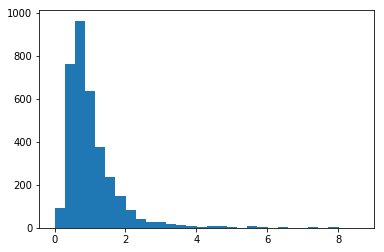

In [390]:
plt.hist(sampleTheta10[sampleTheta10<10], bins=30)